
# Data Augmentation notebook

This notebook shows examples for the functions of the boxsers package related to data augmentation.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

from boxsers.visual_tools import spectro_plot, distribution_plot
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor
from boxsers.data_augmentation import aug_noise, aug_mixup, aug_linslope, aug_offset, aug_multiplier, aug_xshift


## Database importation and label encoding

---

**Important Function/Class used :** 
- ``LabelBinarizer`` (class from Scikit Learn): Converts label to binary label matrix.

**Comments :**
 - The labels occupy the first column (column 0) of the dataframe, which can be addressed by its tag 'Classes'.
 - The spectra occupy the remaining columns of the dataframe, the associated coordinates are therefore [0: , 1:].
 

In [2]:
df = pd.read_hdf('Bile_acids_27_07_2020.h5', key='df')  # Load bile acids dataframe
wn = np.load('Raman_shift_27_07_2020.npy')  # Load Wavenumber (Raman shift)
display(df)  # Prints a detailed overview of the imported dataframe "df"

# Features extraction: Exports dataframe spectra as a numpy array (value type = float64).
sp = df.iloc[:, 1:].to_numpy()
# Labels extraction: Export dataframe classes into a numpy array of string values.
label = df.loc[:, 'Classes'].values

# Creating instance of LabelBinarizer
labelbinarizer = LabelBinarizer()

# Encodes labels (value type = string) as binary label [1 0 0 0] [0 0 0 1] [0 1 0 0], ...
lab_binary = labelbinarizer.fit_transform(label)

,Classes,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,Blank,14698.0,14600.0,14933.0,15008.0,14864.0,14869.0,14982.0,14968.0,15026.0,...,5813.0,5717.0,5795.0,5865.0,5648.0,5667.0,5656.0,5764.0,5741.0,5807.0
1,Blank,14622.0,14329.0,14766.0,15041.0,14927.0,14907.0,14783.0,15076.0,15234.0,...,5778.0,5897.0,5735.0,5778.0,5695.0,5734.0,5627.0,5845.0,5666.0,5805.0
2,Blank,15225.0,15343.0,15557.0,15533.0,15518.0,15601.0,15366.0,15541.0,15645.0,...,5617.0,5574.0,5801.0,5672.0,5629.0,5648.0,5608.0,5690.0,5744.0,5726.0
3,Blank,15052.0,14922.0,15215.0,15310.0,15437.0,15208.0,15166.0,15625.0,15499.0,...,5740.0,5808.0,5958.0,5881.0,5828.0,5757.0,5877.0,5826.0,5822.0,5785.0
4,Blank,14211.0,14370.0,14346.0,14550.0,14601.0,14521.0,14431.0,14757.0,14741.0,...,5558.0,5607.0,5706.0,5747.0,5604.0,5546.0,5563.0,5682.0,5558.0,5543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,TCDCA,13532.0,13549.0,13639.0,13916.0,13721.0,13758.0,13736.0,13828.0,13827.0,...,5694.0,5746.0,5649.0,5562.0,5608.0,5601.0,5603.0,5616.0,5528.0,5611.0
4796,TCDCA,13277.0,13086.0,13472.0,13415.0,13415.0,13459.0,13657.0,13387.0,13615.0,...,5743.0,5801.0,5769.0,5669.0,5639.0,5709.0,5718.0,5743.0,5768.0,5616.0
4797,TCDCA,14002.0,13930.0,13961.0,14149.0,14165.0,14155.0,14292.0,14107.0,14119.0,...,5679.0,5670.0,5718.0,5721.0,5578.0,5639.0,5596.0,5614.0,5637.0,5614.0
4798,TCDCA,14140.0,14022.0,14204.0,14271.0,14285.0,14313.0,14375.0,14258.0,14522.0,...,5936.0,6091.0,5975.0,6084.0,5859.0,5919.0,5950.0,5957.0,5997.0,5910.0


## Data augmentation individual methods

---

**Important Function/Class used :** 

   - ``spectro_plot`` : Returns a plot with the selected spectrum(s)
   - ``aug_noise`` : Generates new spectra by adding random noise
   - ``aug_xshift`` : Generates new spectra with pixel shifts
   - ``aug_offset`` : Generates new spectra by adding an intensity offset
   - ``aug_multiplier`` : Generates new spectra by adding multiplicative factors
   - ``aug_linslope`` : Generates new spectra by the addition of a linear slopes
   - ``aug_mixup`` : Generates new spectra using a linear combinaison process inspired by (Zhang, Hongyi, et al. 2017).
 


**Comments :**
- In this notebook, spectra are preprocessed before the application of data augmentation methods to provide a better visualization.
- Write ``help(name of the function or the class)`` to get more information, namely on the parameters. 


In [3]:
def preprocessing_method(x):
    x = als_baseline_cor(x, lam=1e4, p=0.001)
    x = savgol_smoothing(x, 15, 3)
    return x

# One spectrum is selected randomly and preprocessed 
random_index = np.random.randint(0, sp.shape[0]-1)
sp_p = preprocessing_method(sp[random_index])  # random spectrum preprocessing
lab_p = lab_binary[random_index]  # corresponding label

print('Row corresponding to the spectrum in the database: ', random_index)
print('Corresponding bile acid: ', label[random_index])

Row corresponding to the spectrum in the database:  3528
Corresponding bile acid:  LCA


### 1. White Gaussian noise addition

- White Gaussian noise with a fixed and uniform standard deviation over the whole spectrum

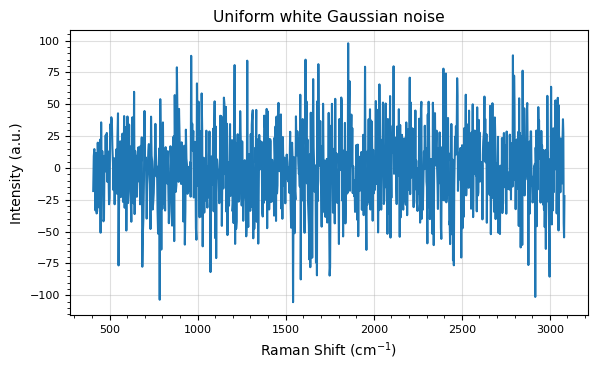

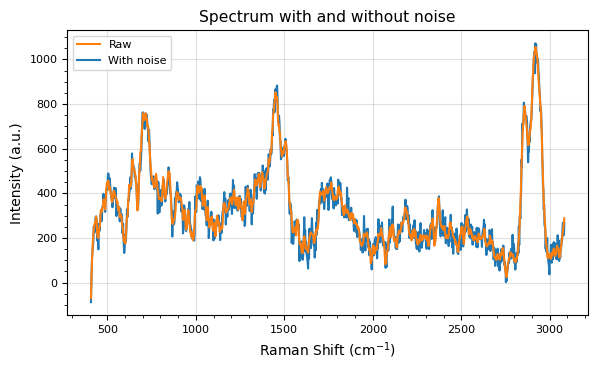

In [4]:
sp_nse, _, nse = aug_noise(sp_p, lab_p, snr=10, quantity=1, noise_type='uniform', return_noise=True)

spectro_plot(wn, nse, title='Uniform white Gaussian noise')
spectro_plot(wn, sp_nse, sp_p, legend=['With noise', 'Raw'], title='Spectrum with and without noise')

- White Gaussian noise whose standard deviation varies over the spectrum and is proportional to the intensity of each pixel. 

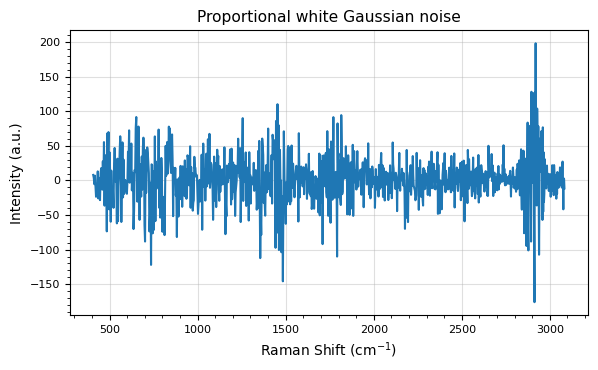

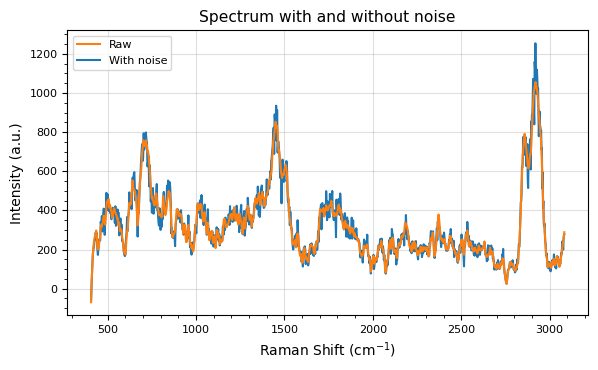

In [5]:
sp_nse, _, nse = aug_noise(sp_p, lab_p, snr=10, quantity=1, noise_type='proportional', return_noise=True)

spectro_plot(wn, nse, title='Proportional white Gaussian noise')
spectro_plot(wn, sp_nse, sp_p, title='Spectrum with and without noise', legend=['With noise', 'Raw'])


### 3. Offset, multiplier and linear slope 


In [8]:
# Another spectrum is selected randomly and preprocessed 
random_index = np.random.randint(0, sp.shape[0]-1)
sp_p = preprocessing_method(sp[random_index])  # random spectrum preprocessing
lab_p = lab_binary[random_index]  # corresponding class

print('Row corresponding to the spectrum in the database: ', random_index)
print('Corresponding bile acid: ', label[random_index])

Row corresponding to the spectrum in the database:  2754
Corresponding bile acid:  GCDCA


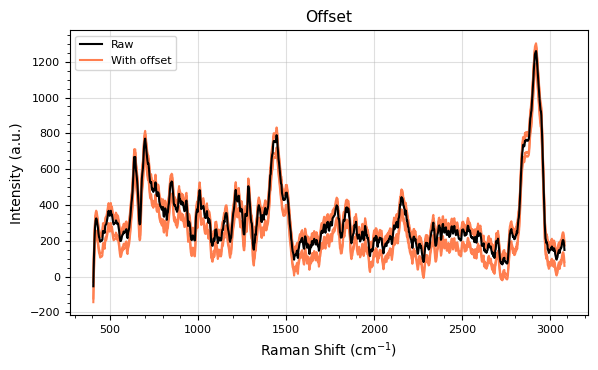

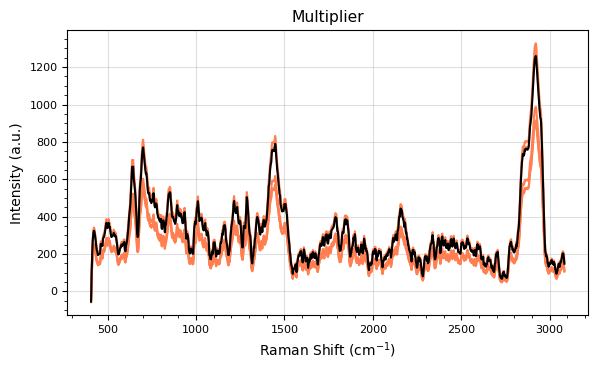

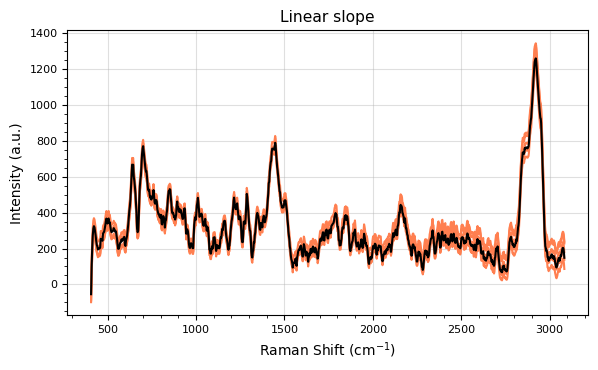

In [9]:
i = 5 
sp_offset, _ = aug_offset(sp_p, lab_p, offset_range=0.3, quantity=i)
sp_mult, _ = aug_multiplier(sp_p, lab_p, mult_range=0.3, quantity=i)
sp_lsp, _ = aug_linslope(sp_p, lab_p, slope_range=0.5, xinter_range=[0, 1], yinter_range=0.1, quantity=i)

color=['coral']*i
color.append('k')

spectro_plot(wn, sp_offset, sp_p, color=color, legend=['With offset', 'Raw'], title='Offset')
spectro_plot(wn, sp_mult, sp_p, color=color,  title='Multiplier')
spectro_plot(wn, sp_lsp, sp_p, color=color,  title='Linear slope')

## Data augmentation pipeline

---

**Important Function/Class used :** 

   - ``spectro_plot`` : Returns a plot with the selected spectrum(s)

**Comments :**
- Write ``help(name of the function or the class)`` to get more information, namely on the parameters. 


In [10]:
def data_aug_pipeline(x, y, i):
    """ pipeline with several data augmentation methods adapted for spectra."""

    # new specta are generated
    x_nse_u, y_nse_u = aug_noise(x, y, snr=10, noise_type='uniform', quantity=i)
    x_nse_p, y_nse_p = aug_noise(x, y, snr=10, noise_type='proportional', quantity=i)
    x_wshft, y_wshft = aug_xshift(x, y, xshift_range=6, quantity=i)
    x_off, y_off = aug_offset(x, y, offset_range=0.3, quantity=i)
    x_mult, y_mult = aug_multiplier(x, y, mult_range=0.3, quantity=i)
    x_slp, y_slp = aug_linslope(x, y, slope_range=0.5, xinter_range=[0, 1], yinter_range=0.1, quantity=i)
    x_mixup, y_mixup = aug_mixup(x, y, n_spec=2, alpha=0.3, quantity=i)

    # stacks all generated spectra and originals in a single array
    x_aug = np.vstack((x, x_nse_u, x_nse_p, x_wshft, x_off, x_mult, x_slp, x_mixup))
    y_aug = np.vstack((y, y_nse_u, y_nse_p, y_wshft, y_off, y_mult, y_slp, y_mixup))

    # spectra and labels are randomly mixed two times
    x_aug, y_aug = shuffle(x_aug, y_aug)
    x_aug, y_aug = shuffle(x_aug, y_aug)
    return x_aug, y_aug


# retrieving augmented data
data_aug_fold=1
sp_aug, lab_aug = data_aug_pipeline(sp, lab_binary, i=data_aug_fold)

print('Data Augmentation', 6*data_aug_fold+1, 'fold :')
print('spectra before/after shapes =', sp.shape, '/', sp_aug.shape)
print('label before/after shapes =', lab_binary.shape, '/', lab_aug.shape)

Data Augmentation 7 fold :
spectra before/after shapes = (4800, 1024) / (38400, 1024)
label before/after shapes = (4800, 6) / (38400, 6)
